# System Identification and Control Design

In [1]:
%load_ext autoreload
%autoreload 2c
import px4tools
import px4tools.logsysid
import pandas
import control
import json
%pylab inline

px4tools.__version__

attempting to monkey patch pandas timedelta series plotting
monkey patch suceeded
No module named 'mpl_toolkits.basemap'

    sudo apt-get install python-basemap
    or:
    conda install basemap

No module named 'mpl_toolkits.basemap'
Populating the interactive namespace from numpy and matplotlib


'0.8.4+0.g83e32e6.dirty'

In [2]:
data = px4tools.process_data(pandas.read_csv('./sess052/log001.csv'))

fit quality 82.95 %


/home/jgoppert/anaconda3/lib/python3.6/site-packages/control/freqplot.py:153: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True);
/home/jgoppert/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/jgoppert/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/jgoppert/anaconda3/lib/python3.6/site-packages/control/freqplot.py:163: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes a

margins (1.7526690451806191, 59.570585699366305, 27.465943042687773, 94.420292453916659)
margins (4.0284208294161816, 64.715611926471198, 9.5771338208048036, 45.784166585896756)
fit quality 85.63 %
margins (2.4130442324686046, 77.373128366434514, 12.721478825065509, 92.286078087227025)
margins (6.8920116242455798, 57.94143019503997, 6.5846319731890679, 33.64476608940786)


/home/jgoppert/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{
    "MC_ROLL_P": 9.414,
    "MC_ROLLRATE_P": 0.101,
    "MC_ROLLRATE_I": 0.098,
    "MC_ROLLRATE_D": 0.002,
    "MC_PITCH_P": 6.881,
    "MC_PITCHRATE_P": 0.062,
    "MC_PITCHRATE_I": 0.056,
    "MC_PITCHRATE_D": 0.002
}


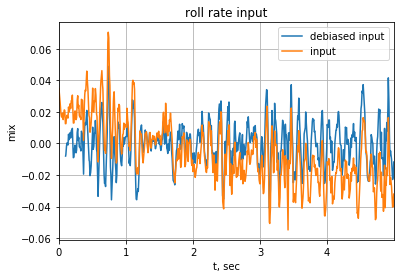

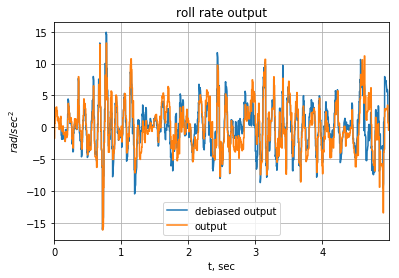

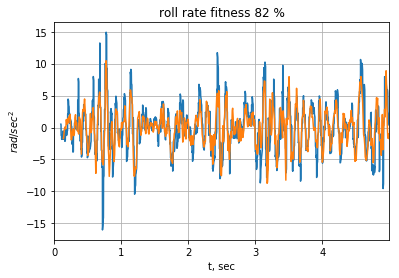

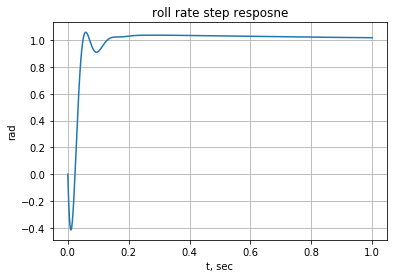

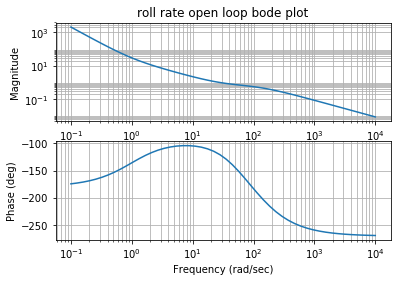

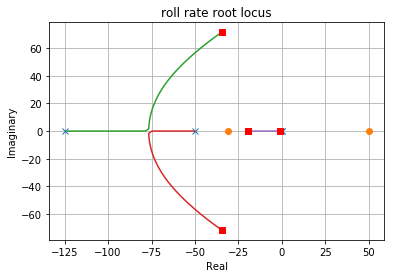

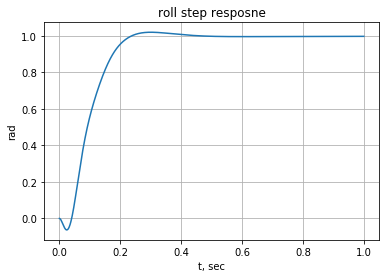

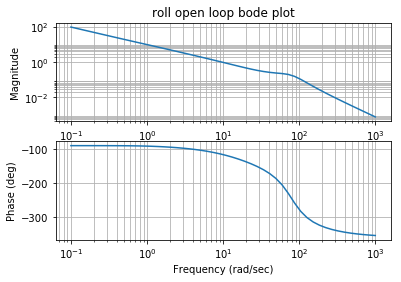

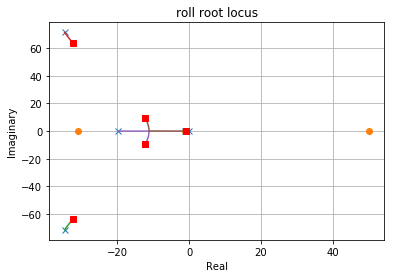

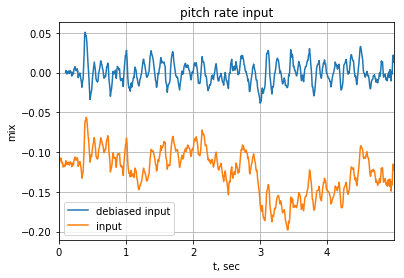

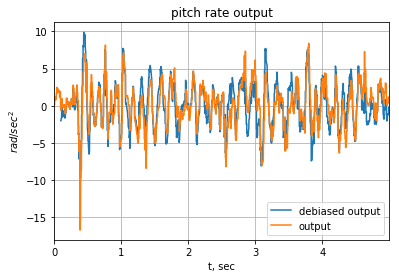

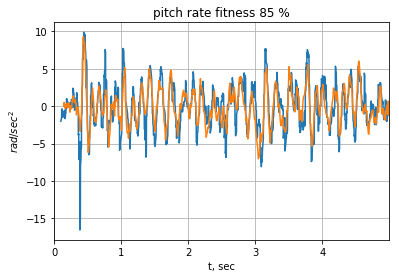

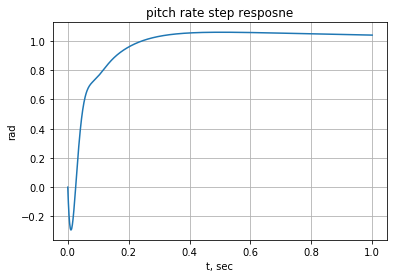

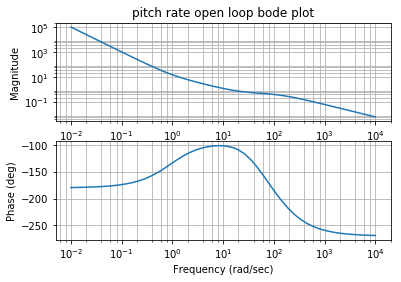

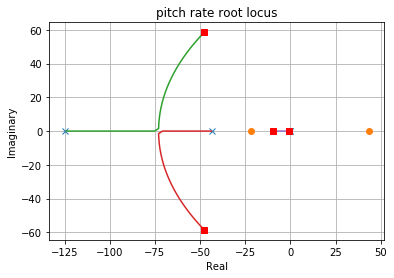

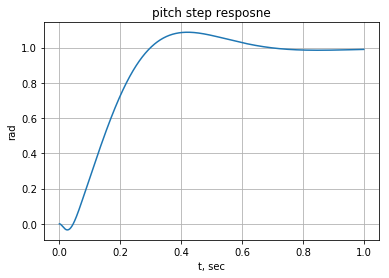

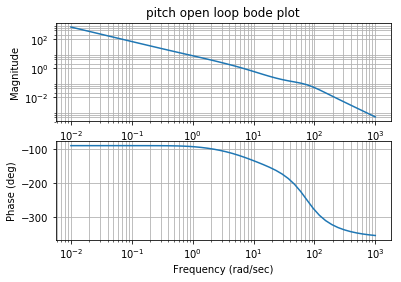

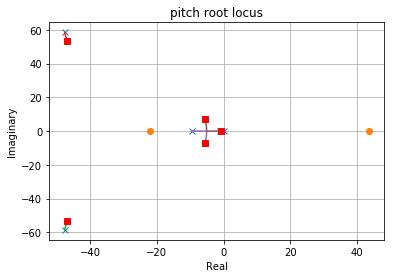

In [3]:
gains, design_data = px4tools.logsysid.control_design(data[23:28],
    do_plot=True)
print(json.dumps(gains, indent=4))

In [4]:
plt.savefig('test.pdf')

In [5]:
gains

OrderedDict([('MC_ROLL_P', 9.4139999999999997),
             ('MC_ROLLRATE_P', 0.10100000000000001),
             ('MC_ROLLRATE_I', 0.098000000000000004),
             ('MC_ROLLRATE_D', 0.002),
             ('MC_PITCH_P', 6.8810000000000002),
             ('MC_PITCHRATE_P', 0.062),
             ('MC_PITCHRATE_I', 0.056000000000000001),
             ('MC_PITCHRATE_D', 0.002)])

In [6]:
!ls

Log based System Identification and Control Design.ipynb
pitch-closed-step.pdf
pitch-open-bode.pdf
pitch rate-closed-step.pdf
pitch rate-debiased-input.pdf
pitch rate-debiased-output.pdf
pitch rate-fit.pdf
pitch rate-open-bode.pdf
pitch rate-rlocus.pdf
pitch rate-step.pdf
pitch-rlocus.pdf
pitch-step.pdf
roll-closed-step.pdf
roll-open-bode.pdf
roll rate-closed-step.pdf
roll rate-debiased-input.pdf
roll rate-debiased-output.pdf
roll rate-fit.pdf
roll rate-open-bode.pdf
roll rate-rlocus.pdf
roll rate-step.pdf
roll-rlocus.pdf
roll-step.pdf
sess052
test.pdf
ulog
ulog analysis.ipynb
ulog noise analysis.ipynb


In [9]:
design_data['G_cl_roll']


            -6.397 s^3 + 115.6 s^2 + 1.001e+04 s + 9906
------------------------------------------------------------------
0.008 s^5 + 0.7205 s^4 + 55.89 s^3 + 1179 s^2 + 1.106e+04 s + 9906

In [10]:
design_data['G_cl_rollrate']


      -0.6795 s^3 + 12.28 s^2 + 1064 s + 1052
--------------------------------------------------
0.008 s^4 + 0.7205 s^3 + 62.28 s^2 + 1064 s + 1052